# E190AP Final Project - Automatic Beatboxing Recognition
### Team: Ankoor Apte and Sidney Cozier

###### Background and motivation: 

Beatboxing can be defined as the art of vocal percussion, or mimicking real drum machines with the human mouth and voice. Beatboxing performances can be done solo or with a group of singers, like in a cappella music. Due to their dependence on physical features (how the human mouth is shaped) and subjective interpretation (how a drum sound is translated to vocal percussion), beatboxing sounds tend to vary significantly across individual performers. However, most beatboxing sounds across performers can be loosely fit to standard drum sounds (e.g. kicks, snares, hi-hats, among others), especially by individuals that are familiar with these standard sounds. 

In this project, we aim to solve the problem of recognizing standard drum sounds used in beatboxing, with the most notable challenge being the variation across artists. 

###### Problem Statement:

Given an audio recording of a solo beatboxing performance, design a tool that recognizes the distinct percussion sounds present in the recording (from a known dictionary of 10 percussion sounds) and identifies when the sounds occur in the recording.

###### Sound Type Dictionary:
Uses Standard Beatboxing Notation (SBN)
1. Kick - B
2. Snare 1 - Pf
3. Snare 2 - Pch
4. Snare 3 - K
5. Snare 4 - ^Ksh
6. Snare roll - rrh
7. Closed hi-hat - t
8. Open hi-hat - ts
9. Rimshot - k
10. Lip Oscillation - BB

###### Final design:
Input - audio query file (.wav)

Output - soundDict, a Python dictionary with 10 keys corresponding to the 10 pre-defined percussion sounds, and values corresponding to time locations in the recording where the given sound type occured.

We chose to implement a Hidden Markov Model with 10 *states* corresponding to each of the percussion sounds. The *observations* are each of the sounds made in the audio query (time-domain signals), and our *models* are multivariate normal distributions that are unique to each sound. 


###### Sections (outline of this notebook):
1. Set up dependencies
2. Observations functions - obtaining observations from audio data
3. Model functions - training models based on ground truth data
4. State functions - estimating states from observations and model 
3. Run - choose an individual audio file and run the beatboxing detection HMM to view resulting transcription
3. Performance testing - F-measure


### Set up dependencies
Import statements, matplotlib and global variables

In [26]:
%matplotlib inline

In [27]:
import numpy as np
import os
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.stats as ss
import miscFuns as mf #python functions we wrote

In [28]:
#Global variables
numDictSounds = 10

### Observations functions

In [29]:
def loadAudioCalcSTFT(queryfile, sr=22050, hop_size=512, win_size=2048): #add in sample rate, hop size, window size stuff later
    ''' TO DO
    '''
    y, sr = lb.core.load(queryfile, sr=sr)
    S = lb.core.stft(y, n_fft=win_size, hop_length=hop_size)
    Smag = np.abs(S)
    return y, sr, Smag #we only use Smag

In [30]:
def obtainObservations(audio, sr = 22050, backtrack=800, model=False):
    ''' TO DO
    '''
    
    #get tempo
    tempo_bpm = lb.beat.tempo(audio, sr=sr)
    tempo_bpm = int(round(tempo_bpm[0]))
    print("Tempo in bpm: ", tempo_bpm)
    
    #determine eighth measure window size in samples
    tempo_bps = tempo_bpm/60.0
    quarterMeasure = 1/tempo_bps #time period for 1 beat, i.e. a quarter measure
    eighthMeasure = quarterMeasure/2
    win_size = int(round(eighthMeasure*sr)) #get window size in samples
    print("8th measure window size:", win_size)
    
    #set librosa peak picker parameters
    premax = 10
    postmax = 10
    preavg = 3
    postavg = 3
    delta = 3.6
    wait = 10
    
    #compute onset envelope for audio and then use librosa peak picker to get beat locations
    oenv = lb.onset.onset_strength(audio, sr=sr)
    beats_frames = lb.util.peak_pick(oenv, pre_max=premax, post_max=postmax, pre_avg=preavg, post_avg=postavg, delta=delta, wait=wait)
    
    #convert to samples
    beats = lb.frames_to_samples(beats_frames)
    
    #create observations array
    if model == True: 
    #we hard-code size of obsvArray to be 40 for model training, because all our training data contains 40 known observations
    #this would be addressed in future iterations
        numObsv = 40 
    else:
        numObsv = numObsv = beats.shape[0]
    obsvArray = np.zeros((win_size, numObsv))
    for i in range(numObsv):
        if i < beats.shape[0]:
            onset = beats[i]
        else:
            onset = beats[-1] #imperfect solution to cases where we get <40 observations, we never hit this case if model==False
        
        #using backtrack parameter, obtain an observation from the input audio by taking a window of size win_size, starting at onset-backtrack
        obsvArray[:,i] = audio[onset-backtrack:onset+win_size-backtrack]
    
    return tempo_bpm, beats, obsvArray

In [31]:
def calcFeatures(obsv, returnFVL=False): 
    '''single obsv: a 1D array representing samples over an eighth measure containing a percussion sound
       returns a feature vector'''
    fVecLen = 8
    F = np.zeros(fVecLen)
    stft = np.abs(lb.core.stft(obsv))
    env = mf.envelope(obsv)
    
    #calculate feature parameters
    maxInd = np.argmax(stft) # Linear/Flattened Index
    maxInds = np.unravel_index(maxInd, stft.shape)
    attack, decay, sustain, release = mf.calcADSR(obsv, env, sr=22050)
    
    F[0] = np.average(obsv) # May or may not keep
    F[1] = maxInds[0] # Frequency (DFT index)
    F[2] = maxInds[1] # Time (in frames)
    F[3] = np.max(stft)   
    F[4] = attack
    F[5] = decay
    F[6] = sustain
    F[7] = release
    
    if returnFVL:
        return F, fVecLen
    else:
        return F

### Model functions
Functions used to train the model - there are two types, a general model that includes all the training data, and an individual-specific model that uses the data for one person

In [32]:
def makeGeneralModel(rec1_directory):
    ''' input: 
        path to folder containing all rec1s
    
        internal variables:
        numFiles - number of files in rec1 folder
        fVec_accum - an array of size (fVecLen, 10) where fVec_accum[:,i] contains a running sum of all fVecs *known* to have state i (of 10 percussion sounds)
        cov_accum - an array of size (fVecLen, 10, fVecLen) where cov_accum[:,i,:] contains a running sum of the outer product of 
        
        output:
        model - (transitions_matrix, means, covs)
                transitions_matrix - np.ones((10,10))/100.0, equal transition probabilities
                means - an array of size (fVecLen, 10) where means[:,i] specifies the mean feature vector for sound type i
                covs - an array of size (fVecLen, 10, fVecLen) where cov[:,i,:] specifies the covariance matrix for sound type i
        
        pseudo-code:
        iterate through each recording, and
            load audio and obtain observations array
            iterate through each observation, and 
                calculate feature vector for observation
                add fVec to fVec_accum[:,i] where i is the *known* sound type for this observation (we know gt)
                
        divide fVec_accum by 4*numFiles to get means
        
        iterate through each recording again, and
            load audio and obtain observations array
            iterate through each observation, and 
                calculate feature vector for observation #redundancy can be fixed?
                calculate diff = fVec - means[:,i] where i is the *known* sound type for this observation (we know gt)
                add np.outer(diff, diff) with shape (fVecLen, fVecLen) to cov_accum[:,i,:]
        
        divide cov_accum by (4*numFiles) - 1, because of lower dof to get covs
    '''
    filenames = os.listdir(rec1_directory)
    filenames.remove('.DS_Store')
    
    #parameters
    numFiles = len(filenames)
    fVecLen = 8
    
    #output data
    means = np.zeros((fVecLen, numDictSounds))
    covs = np.zeros((fVecLen, numDictSounds, fVecLen))
    transition_matrix = np.ones((numDictSounds,numDictSounds))/(numDictSounds**2) #Equal probabilities to avoid bias
    
    #get fVec_accum
    fVec_accum = np.zeros((fVecLen, numDictSounds))
    print('Calculating means...')
    for file in filenames:
        print('File:', file)
        #load audio and get observations+tempo
        audio, sr, Smag = loadAudioCalcSTFT(rec1_directory+file)
        tempo, beats, obsvArray = obtainObservations(audio, sr=22050, model=True) #tempo and observations need to be looked at, so that we're getting clear samples of each sound
        numObsv = obsvArray.shape[1]
        print('numObsv:', numObsv)
        
        #add breakpoint here if numObsv != 40, or if anything else is unexpected (e.g. tempo != 120)
        #we need this for the rest of the code to work
        
        #iterate through observations
        for obsv in range(numObsv):
            (sNum, oNum) = divmod(obsv, 4) # Sound Number and observation number (4 observations of each sound)
            thisFeatVec = calcFeatures(obsvArray[:,obsv])
            fVec_accum[:,sNum] += thisFeatVec
            
    #calculate means
    means = np.divide(fVec_accum,4*numFiles)
    
    #get cov_accum
    cov_accum = np.zeros((fVecLen, numDictSounds, fVecLen))
    print('Calculating covs...')
    for file in filenames:
        print('File:', file)
        #load audio and get observations+tempo
        audio, sr, Smag = loadAudioCalcSTFT(rec1_directory+file)
        tempo, beats, obsvArray = obtainObservations(audio, sr=22050, model=True) #tempo and observations need to be looked at, so that we're getting clear samples of each sound
        print('numObsv:', numObsv)
        
        #add breakpoint here if numObsv != 40, or if anything else is unexpected (e.g. tempo != 120)
        #we need this for the rest of the code to work
        
        #iterate through observations
        for obsv in range(numObsv):
            (sNum, oNum) = divmod(obsv, 4) # Sound Number and observation number (4 observations of each sound)
            thisFeatVec = calcFeatures(obsvArray[:,obsv])
            diff = thisFeatVec - means[:,sNum]
            cov_accum[:,sNum,:] += np.outer(diff, diff)
    
    #calculate covs
    covs = np.divide(cov_accum,(4*numFiles)-1)
    
    model = (transition_matrix, means, covs)
    return model

In [33]:
def makeModel(filename='audio_data/rsalazar_rec3.wav', gtlabels=None):
    ''' Function for making model based on individual sound recordings, i.e. rec1
        
        NOTE: For ground truth labels to work, ONLY use this function with rec1.
    '''
    transition_matrix = np.ones((10,10))/100 # Equal probabilities to avoid bias
    
    audio, sr, Smag = loadAudioCalcSTFT(filename)
    tempo, beats, obsvArray = obtainObservations(audio, model=True)
    
#     sNum = oNum = 0; 
    
    # Loop through all observations
    for obsv in np.arange(obsvArray.shape[1]):
        (sNum, oNum) = divmod(obsv, 4) # Sound Number and observation number (4 observations of each sound)
        
        # Catch Errors
        if sNum > numDictSounds-1:
            print('Warning: Sound count higher than expected. Observations possibly flawed.')
            break
        
        # Calculate feature vector of observation
        thisFeatVec, fVecLen = calcFeatures(obsvArray[:,obsv], returnFVL=True)
        
        if obsv==0: # First observation of a sound 
            thisSound_fVecs = np.zeros((fVecLen,4)) # 4 feature vectors for 1 sound
            thisSound_covs = np.zeros((fVecLen,4,fVecLen)) # 4 Covariance Matrices for each sound
            fVecs_avg = np.zeros((fVecLen,numDictSounds)) # Initialize total means matrix
            fVecs_cov = np.zeros((fVecLen,numDictSounds,fVecLen)) # Each covariance hass fvl x fvl dimensions
        
        # add feature vector to current group
        thisSound_fVecs[:,oNum] = thisFeatVec
        
        # add Covariance matrix to current group
        d1 = (thisFeatVec - fVecs_avg[:,sNum])
        outer = np.outer(d1.reshape((fVecLen,1)), d1.reshape((1,fVecLen))) #don't need to reshape if we are using outer
        thisSound_covs[:,oNum,:] = outer
        
        if oNum == 3: # Last observation of a sound
            fVecs_avg[:,sNum] = np.mean(thisSound_fVecs, axis=1)
            fVecs_cov[:,sNum,:] = (np.sum(thisSound_covs, axis=1))/3

    return (transition_matrix, fVecs_avg, fVecs_cov)

### State functions
Functions used to estimate the states, given observations and a model.

In [34]:
def generatePairwiseSimilarityMatrix(F, means, covar):
    '''
    Compute a similarity matrix containing the conditional pdf value of a given feature vector given the chord type.
    
    Arguments:
    M is feature vector size
    F -- feature matrix of size (M, N), where N is the number of audio frames
    means -- a matrix of size (M, 10) whose i-th column specifies the mean chroma feature vector for
        the ith percussion sound
    covar -- matrix of size (M,10,M) specifying the estimated covariance matrix for all percussion sounds

    
    Returns:
    S -- matrix of size (10, N) whose (i,j)-th element specifies the log of the conditional pdf value 
        of observing the j-th feature vector F[:,j] given that the percussion sound was of type i (following the order from our presentation)
    '''
    numObsv = F.shape[1]
    numDictSounds = means.shape[1]
    S = np.zeros((numDictSounds, numObsv))
    
    for i in range(numDictSounds):
        cov = covar[:,i,:]
        for j in range(numObsv):
            S[i,j] = ss.multivariate_normal.logpdf(F[:,j], mean = means[:,i], cov = cov, allow_singular=True) #non-ideal
    return S

In [35]:
def runBeatboxingRecognitionHMM(obsvArray, model):
    '''
    Estimate the beatboxing sound given an array of sounds
    
    Arguments:
    obsvArray -- array of shape (m,n) where m is the 8th measure window size and n is the number of observations in the audio recording
    model -- trained hidden markov model
    
    Returns:
    soundDict -- dictionary where the keys are the ten pre-defined beatboxing sounds, and the values are lists of the 
    location(s) of the sound in the query file
    this can be used to make transcriptions of the beatboxing recording
    '''
    soundDict = {}

    numObsv = obsvArray.shape[1]
    (transition_matrix, means, covar) = model
    
    numFeats = 8
    F = np.zeros((numFeats,numObsv))
    for obsv in range(numObsv):
        F[:,obsv] = calcFeatures(obsvArray[:,obsv])

    S = generatePairwiseSimilarityMatrix(F, means, covar) 
    
    beat_transcription = []
    
    for obsv in range(numObsv):
        beat_transcription += [mf.num2Sound[np.argmax(S[:,obsv])]]
    
    return beat_transcription

### Run
Choose an audio file from our dataset and run the beatboxing detection HMM to view results.

In [36]:
#use this to set queryfile from data and listen to audio
queryfile = 'audio_data/rsalazar_rec4.wav'
ipd.Audio(queryfile)

In [37]:
#Get observations from audio
audio, sr, Smag = loadAudioCalcSTFT(queryfile)
tempo, beats, obsvArray = obtainObservations(audio)
print(tempo)
print(beats)

Tempo in bpm:  144
8th measure window size: 4594
144
[  2560  11776  24576  43008  65536  76288  85504 104448 123904 138240
 148480]


Number of observations:  11


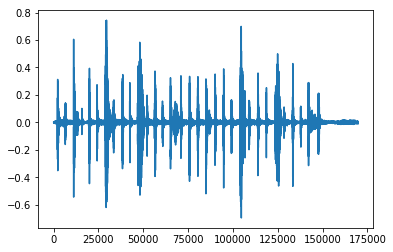

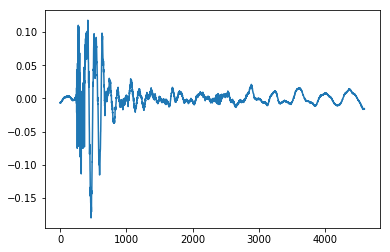

In [21]:
#Visualization, playing around with data
print("Number of observations: ", obsvArray.shape[1])
plt.figure(1)
plt.plot(audio)
plt.show()

#set observation index
obsv_idx = 9
plt.figure(2)
plt.plot(obsvArray[:,obsv_idx])

# plt.figure(3)
# plt.imshow(Smag, origin = 'lower', cmap = 'jet')

In [14]:
#Train general model - this takes about 2 minutes
model = makeGeneralModel('training_data/')

Calculating means...
File: scozier_rec1.wav
Tempo in bpm:  123
8th measure window size: 5378
numObsv: 40
File: rsalazar_rec1.wav
Tempo in bpm:  117
8th measure window size: 5654
numObsv: 40
File: aapte_rec1.wav
Tempo in bpm:  30
8th measure window size: 22050
numObsv: 40
File: mhapte-selassie_rec1.wav
Tempo in bpm:  117
8th measure window size: 5654
numObsv: 40
File: cjones_rec1.wav
Tempo in bpm:  129
8th measure window size: 5128
numObsv: 40
File: mkania_rec1.wav
Tempo in bpm:  136
8th measure window size: 4864
numObsv: 40
Calculating covs...
File: scozier_rec1.wav
Tempo in bpm:  123
8th measure window size: 5378
numObsv: 40
File: rsalazar_rec1.wav
Tempo in bpm:  117
8th measure window size: 5654
numObsv: 40
File: aapte_rec1.wav
Tempo in bpm:  30
8th measure window size: 22050
numObsv: 40
File: mhapte-selassie_rec1.wav
Tempo in bpm:  117
8th measure window size: 5654
numObsv: 40
File: cjones_rec1.wav
Tempo in bpm:  129
8th measure window size: 5128
numObsv: 40
File: mkania_rec1.wav
Te

In [24]:
#run the HMM
output = runBeatboxingRecognitionHMM(obsvArray, model)#run HMM and get sound dictionary

In [25]:
output

['B', 'K', 'B', 'B', '^Ksh', 'B', 'K', 'Pf', 'ts', 'B', 't']

### Performance Evaluation
Use F-measure to characterize our system.